Adam Ten Hoeve, Jared Pino, Joseph Plata  
COMP 4431 - Data Mining  
Assignment 5

In [1]:
# Load necesary packages
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, MeanShift, estimate_bandwidth
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Last assignment, we explored the iris dataset to get a better understanding of whether the different classes where linearly seperable and which features resulted in the biggest differences between the classes.

From that analysis, we came to the conclusions that one of the classes is linearly seperable from the other two, but the latter two are not linearly seperable. We also saw that the petal width and length where better at determining differences between species than the sepal length or width. Doing some feature engineering, we also found that petal area was a good indicator of species. Let's use these findings to do some clustering on this data.

The purpose of clustering this data is to determine which cluster algorithm results in labels that are most accurate to the original labels. This way, if we didn't know the labels, we would be able to use our clustering algorithms to match similarly sized petals and sepals.

We have to start by loading in the data. From the previous assignment, we know that there is not any missing or miscoded values in the dataset.

In [2]:
# Load the data
iris = load_iris()
target_names = iris["target_names"]
data = iris["data"]
target = iris["target"]
feature_names = iris["feature_names"]

# Store the data in a pandas dataframe
iris = pd.DataFrame(data)
iris.columns = feature_names
iris["species"] = target
iris["species"] = iris["species"].astype("category")

# Feature Engineering: Calculate the petal area, sepal area, and total area
iris['sepal area (cm^2)'] = iris['sepal length (cm)'] * iris['sepal width (cm)']
iris['petal area (cm^2)'] = iris['petal length (cm)'] * iris['petal width (cm)']
iris['total area (cm^2)'] = iris['petal area (cm^2)'] * iris['sepal area (cm^2)']

Before jumping straight into clusteering, we may want to reduce the dimensionality of our data. Right now, we have $7$ features that our algorithms will have to process, which could be slow. From our explanatory data analysis, we know that the sepal length and widths where generally less useful than the petal length and width, so it is possible that they could be removed. But instead of removing those features off of a hunch, we can calculate the Principal Components of the data, which will be pointed in the directions of greatest variance. With PCA, we may be able to account for a similar amount of variation in the data with fewer features, which will speed up our clustering algorithms.

One thing to note is, with PCA, we need to be careful not to include our target dimension in our calculations. Otherwise, our principal components would be heavily skewed towards that dimension, which would affect our clustering algorithms.

In [3]:
# Create a series of just the labels
y = iris['species']
# Create a dataframe without the class labels.
x = iris.drop('species', axis=1)
# Scale the features
x = MinMaxScaler().fit_transform(x)

# Convert the scaled data back into a dataframe
feature_columns = ['feature'+str(i) for i in range(x.shape[1])]
features_scaled = pd.DataFrame(x,columns=feature_columns)
features_scaled.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6
0,0.222222,0.625000,0.067797,0.041667,0.392108,0.010787,0.008326
1,0.166667,0.416667,0.067797,0.041667,0.234765,0.010787,0.006274
2,0.111111,0.500000,0.050847,0.041667,0.251748,0.009518,0.005796
3,0.083333,0.458333,0.084746,0.041667,0.212787,0.012056,0.006651
4,0.194444,0.666667,0.067797,0.041667,0.399600,0.010787,0.008423


In [4]:
# Transform our features to Principal Components
pca = PCA()
pca_iris = pca.fit_transform(x)

In [5]:
# The actual numerical percentages of variance explained by each PC
pca.explained_variance_ratio_

array([8.34355174e-01, 1.27541025e-01, 2.57598750e-02, 7.28895366e-03,
       3.85631818e-03, 1.10459875e-03, 9.40547445e-05])

Text(0.5, 0, 'Principal Component')

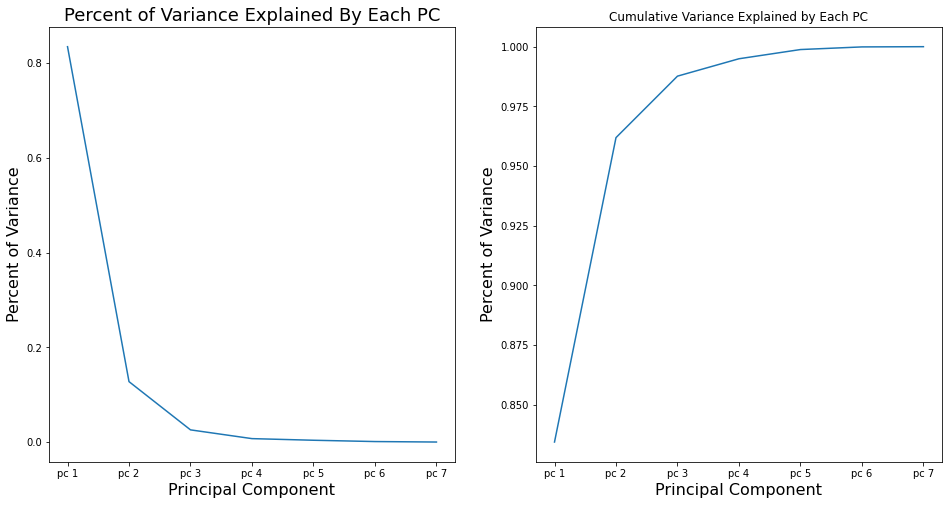

In [6]:
# Let's plot the amount of variation described by each PC
pc = ["pc 1", "pc 2", "pc 3", "pc 4", "pc 5", "pc 6", "pc 7"]
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.lineplot(x=pc, y=pca.explained_variance_ratio_, ax=ax[0])
ax[0].set_title('Percent of Variance Explained By Each PC', size=18)
ax[0].set_ylabel('Percent of Variance', size=16)
ax[0].set_xlabel('Principal Component', size=16)

sns.lineplot(x=pc, y=np.cumsum(pca.explained_variance_ratio_), ax=ax[1])
ax[1].set_title("Cumulative Variance Explained by Each PC")
ax[1].set_ylabel("Percent of Variance", size=16)
ax[1].set_xlabel("Principal Component", size=16)

From these plots, we can see that the first three principal components account for almost $99\%$ of the variance in the data. That means these three principal components provide as much information as all seven of the features of our base dataset. This should help reduce the cost of training all our clustering algorithms. But, just to be sure we are not losing too much information, we should test a clustering model fit the original data and the PCA transformed data, and see if they are the same. Otherwise, we could be losing model performance without realizing it.

For now, let's create a dataset with only the first three principal components.

In [7]:
#final principal component dataset with 3 components
pca_iris = PCA(n_components=3)
x_pca = pca_iris.fit_transform(x)

Now it's time to test K-Means on both the original and 3 Principal Component datasets. But we're going to need to find the optimal number of clusters $k$ first. Our prior knowledge is that there are three species of iris in the dataset, but that information could be wrong or unknown in other circumstances. We can find the optimal number of clusters by fitting many K-Means algorithms to the data, each with a different $k$, and seeing at which $k$ the model stops improving. This is called an "elbow plot."

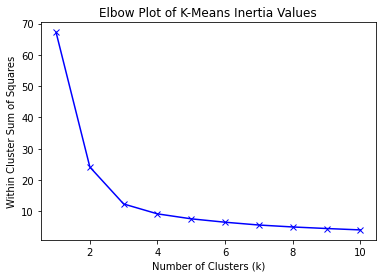

In [8]:
# Finding the optimum number of clusters for k-means classification
wcss = []  # Within cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss, 'bx-')
plt.title('Elbow Plot of K-Means Inertia Values')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

The "elbow" of the plot is the value of the $x$-axis that the curve begins to level out. For our plot, the elbow is when $k=3$. An argument could be made for $k=4$, but we will go with $k=3$ as it agrees with our prior knowledge of the dataset.

Now let's fit a K-Means model to each of our two datasets, each with $k=3$, and see how they compare.

In [9]:
# Initialize the number of clusters
k=3

In [10]:
# Evaluations for KMeans on original data
km_ori = KMeans(n_clusters=3, init = "k-means++", random_state=0).fit(x)
# Save a dataframe of the label and cluster of each point
km_ori_results = pd.DataFrame(list(zip(y, km_ori.labels_)), columns=["species", "cluster"])

# Reassigns labels of clusters to be those of the classes
for c in range(k):
    cluster = pd.DataFrame(km_ori_results[km_ori_results['cluster'] == c].groupby('species').size())
    cluster.columns=['Size']
    
    new = cluster.index[cluster['Size'] == cluster['Size'].max()].tolist()

    rowIndex = km_ori_results.index[km_ori_results['cluster'] == c]
    km_ori_results.loc[rowIndex, 'transLabel'] = new[0]
    
km_ori_correct = (iris['species'] == km_ori_results['transLabel']).sum()
km_ori_accuracy = round(km_ori_correct/km_ori_results.shape[0],3)

km_ori_silhouette = round(metrics.silhouette_score(x, km_ori_results['transLabel'], metric='sqeuclidean'), k)
km_ori_homogeneity = round(metrics.homogeneity_score(y, km_ori_results['transLabel']), k)
km_ori_completeness = round(metrics.completeness_score(y, km_ori_results['transLabel']), k)
km_ori_vMeasure = round(metrics.v_measure_score(y, km_ori_results['transLabel']), k)
km_ori_adjRand = round(metrics.adjusted_rand_score(y, km_ori_results['transLabel']), k)
km_ori_adjMutual = round(metrics.adjusted_mutual_info_score(y, km_ori_results['transLabel']), k)

km_ori_scores = [km_ori_accuracy, km_ori_silhouette, km_ori_homogeneity, km_ori_completeness, \
                 km_ori_vMeasure, km_ori_adjRand, km_ori_adjMutual]

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [11]:
# Evaluations for KMeans on PCA data
km_pca = KMeans(n_clusters=3, init = "k-means++", random_state=0).fit(x_pca)
# Save a dataframe of the label and cluster of each point
km_pca_results = pd.DataFrame(list(zip(y, km_pca.labels_)), columns=["species", "cluster"])

# Reassigns labels of clusters to be those of the classes
for c in range(k):
    cluster = pd.DataFrame(km_pca_results[km_pca_results['cluster'] == c].groupby('species').size())
    cluster.columns=['Size']
    
    new = cluster.index[cluster['Size'] == cluster['Size'].max()].tolist()

    rowIndex = km_pca_results.index[km_pca_results['cluster'] == c]
    km_pca_results.loc[rowIndex, 'transLabel'] = new[0]
    
km_pca_correct = (iris['species'] == km_pca_results['transLabel']).sum()
km_pca_accuracy = round(km_pca_correct/km_pca_results.shape[0], 3)

km_pca_silhouette = round(metrics.silhouette_score(x_pca, km_pca_results['transLabel'], metric='sqeuclidean'), k)
km_pca_homogeneity = round(metrics.homogeneity_score(y, km_pca_results['transLabel']), k)
km_pca_completeness = round(metrics.completeness_score(y, km_pca_results['transLabel']), k)
km_pca_vMeasure = round(metrics.v_measure_score(y, km_pca_results['transLabel']), k)
km_pca_adjRand = round(metrics.adjusted_rand_score(y, km_pca_results['transLabel']), k)
km_pca_adjMutual = round(metrics.adjusted_mutual_info_score(y, km_pca_results['transLabel']), k)

km_pca_scores = [km_pca_accuracy, km_pca_silhouette, km_pca_homogeneity, km_pca_completeness, \
                 km_pca_vMeasure, km_pca_adjRand, km_pca_adjMutual]

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [12]:
# Display the scores
print("K-Means (No PCA):")
print(f"Accuracy Score: {km_ori_accuracy}")
print(f"Silhouette Score: {km_ori_silhouette}")
print(f"Homogeneity Score: {km_ori_homogeneity}")
print(f"Completeness Score: {km_ori_completeness}")
print(f"V-Measure Score: {km_ori_vMeasure}")
print(f"Adjusted Rand Score: {km_ori_adjRand}")
print(f"adjusted_mutual_info_score: {km_ori_adjMutual}")

print()

print("K-Means (with PCA):")
print(f"Accuracy Score: {km_pca_accuracy}")
print(f"Silhouette Score: {km_pca_silhouette}")
print(f"Homogeneity Score: {km_pca_homogeneity}")
print(f"Completeness Score: {km_pca_completeness}")
print(f"V-Measure Score: {km_pca_vMeasure}")
print(f"Adjusted Rand Score: {km_pca_adjRand}")
print(f"adjusted_mutual_info_score: {km_pca_adjMutual}")

K-Means (No PCA):
Accuracy Score: 0.9
Silhouette Score: 0.721
Homogeneity Score: 0.77
Completeness Score: 0.786
V-Measure Score: 0.778
Adjusted Rand Score: 0.745
adjusted_mutual_info_score: 0.767

K-Means (with PCA):
Accuracy Score: 0.9
Silhouette Score: 0.728
Homogeneity Score: 0.77
Completeness Score: 0.786
V-Measure Score: 0.778
Adjusted Rand Score: 0.745
adjusted_mutual_info_score: 0.767


Well, the results between the models are very similar, aren't they. They have the exact same accuracy, with only slight differences in the other metrics. In fact, the two models may have resulted in the same clusterings. Let's take a look at the proportion of matching clusters between the two models.

In [13]:
# Proportion of clusters that where the same across models
np.sum(km_ori_results["transLabel"] == km_pca_results["transLabel"]) / len(x)

1.0

Let's take a look at the confusion matrices for our two models. This should tell use the differences in results between the models.

In [14]:
# Define functions to calculate the confusion matrix for a specific clustering model's result matrix.
def num_cluster_in_label(df, label, cluster):
    # Helper function to calculate the number of points with "label" that are within "cluster"
    a = np.sum(df.loc[df["species"]==label]["transLabel"]==cluster)
    return a

def clustering_conf_matrix(df_results, k):
    # Initialize k*k confusion matrix
    conf_matrix = np.zeros((k, k))
    # For each label-cluster pair, calculate the number of occurances
    for label in range(k):
        for cluster in range(k):
            conf_matrix[label, cluster] = num_cluster_in_label(df_results, label, cluster)

    return(conf_matrix)

In [15]:
# Confustion Matrix of Original Data
# NOTE: columns are clusters, rows are actual labels
clustering_conf_matrix(km_ori_results, 3)

array([[50.,  0.,  0.],
       [ 0., 49.,  1.],
       [ 0., 14., 36.]])

In [16]:
# Confustion Matrix of PCA data
clustering_conf_matrix(km_pca_results, 3)

array([[50.,  0.,  0.],
       [ 0., 49.,  1.],
       [ 0., 14., 36.]])

The models resulted in the exact same clusters! That's good news for our PCA dataset, that we were able to get the same results out of $3$ principal components as we where able to get out of all $7$ features. Because of this outcome, we could use the PCA set on our following models. However, after some experimentation, we determined that fitting the models to the original dataset provided noticably better results for the rest of the models, so that is what we will use moving forward.

The confusion matrices tell that our model is overreaching cluster $1$ into cluster $2$. This cluster mixup is expected from our exploratory analysis. Before we move on, let's visualize our clusters, to see if everything is working as we think it should be.

Text(0.5, 1.0, 'Scatterplot of KMeans Clustering, k=3')

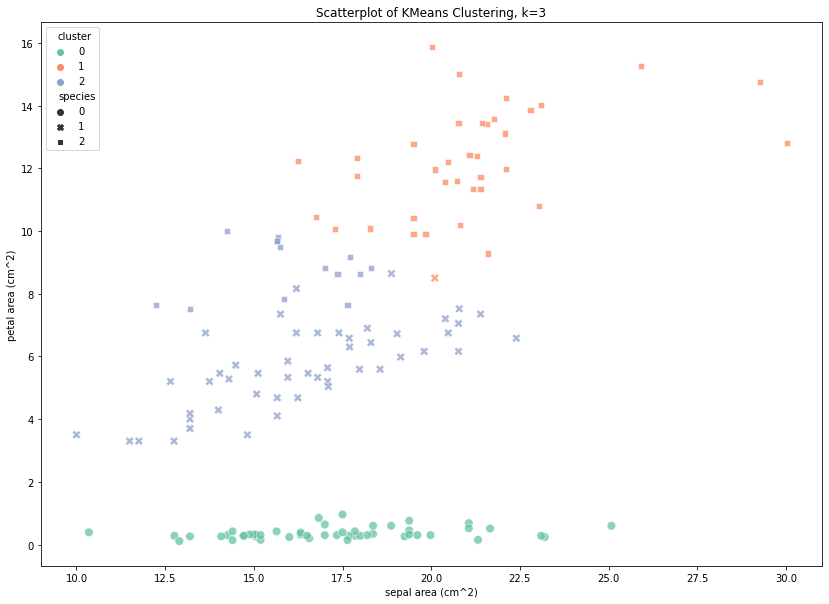

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.scatterplot(data=iris, 
                x="sepal area (cm^2)", 
                y="petal area (cm^2)", 
                hue=km_ori_results["cluster"], 
                style=y,
                s=75,
                alpha=0.75,
                palette="Set2",
                ax=ax)
ax.set_title("Scatterplot of KMeans Clustering, k=3")

From our figure, we can see that the parts of the clusters that overlap with the incorrect labels. It's almost along a diagonal that the points are being misclassified.

We've finished our KMeans clustering, so let's take a look at some other clustering algorithms. Another common clustering algorithm is Hierarchical Clustering, also called Agglomerative Clustering in SKLearn. This method we will recursively merge paris of points that are closest together into "clusters." For our model, we will use euclidean distance and keep $k=3$ clusters to match the KMeans algorithms. Let's fit a hierarchical clustering model to our PCA dataset. 

In [18]:
agg_model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
agg_model.fit(x)

# Store the labels in a dataframe
agg_results = pd.DataFrame(list(zip(y, agg_model.labels_)), columns=["species", "cluster"])

# Reassigns labels of clusters to be those of the classes
for c in range(k):
    cluster = pd.DataFrame(agg_results[agg_results['cluster'] == c].groupby('species').size())
    cluster.columns=['Size']
    
    new = cluster.index[cluster['Size'] == cluster['Size'].max()].tolist()

    rowIndex = agg_results.index[agg_results['cluster'] == c]
    agg_results.loc[rowIndex, 'transLabel'] = new[0]

# Calculate evaluation metrics for the hierarchical model
agg_correct = (iris['species'] == agg_results['transLabel']).sum()
agg_accuracy = round(agg_correct/agg_results.shape[0], 3)

agg_silhouette = round(metrics.silhouette_score(x, agg_results['transLabel'], metric='sqeuclidean'), k)
agg_homogeneity = round(metrics.homogeneity_score(y, agg_results['transLabel']), k)
agg_completeness = round(metrics.completeness_score(y, agg_results['transLabel']), k)
agg_vMeasure = round(metrics.v_measure_score(y, agg_results['transLabel']), k)
agg_adjRand = round(metrics.adjusted_rand_score(y, agg_results['transLabel']), k)
agg_adjMutual = round(metrics.adjusted_mutual_info_score(y, agg_results['transLabel']), k)

agg_scores = [agg_accuracy, agg_silhouette, agg_homogeneity, agg_completeness, \
              agg_vMeasure, agg_adjRand, agg_adjMutual]

D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [19]:
print("Hierarchical Clustering:")
print(f"Accuracy Score: {agg_accuracy}")
print(f"Silhouette Score: {agg_silhouette}")
print(f"Homogeneity Score: {agg_homogeneity}")
print(f"Completeness Score: {agg_completeness}")
print(f"V-Measure Score: {agg_vMeasure}")
print(f"Adjusted Rand Score: {agg_adjRand}")
print(f"adjusted_mutual_info_score: {agg_adjMutual}")

Hierarchical Clustering:
Accuracy Score: 0.96
Silhouette Score: 0.668
Homogeneity Score: 0.864
Completeness Score: 0.864
V-Measure Score: 0.864
Adjusted Rand Score: 0.886
adjusted_mutual_info_score: 0.862


From the numerical evaluation, we can see that the accuracy of the Hierarchical model is better than that of the KMeans model. The other metrics also mirror this conclusion, that the Hierarchical model performs better than our KMeans model. Let's take a look at how the clusters actually aligned with the species labels.

In [20]:
clustering_conf_matrix(agg_results, 3)

array([[50.,  0.,  0.],
       [ 0., 48.,  2.],
       [ 0.,  4., 46.]])

Text(0.5, 1.0, 'Scatterplot of Hierarchical Clustering, k=3')

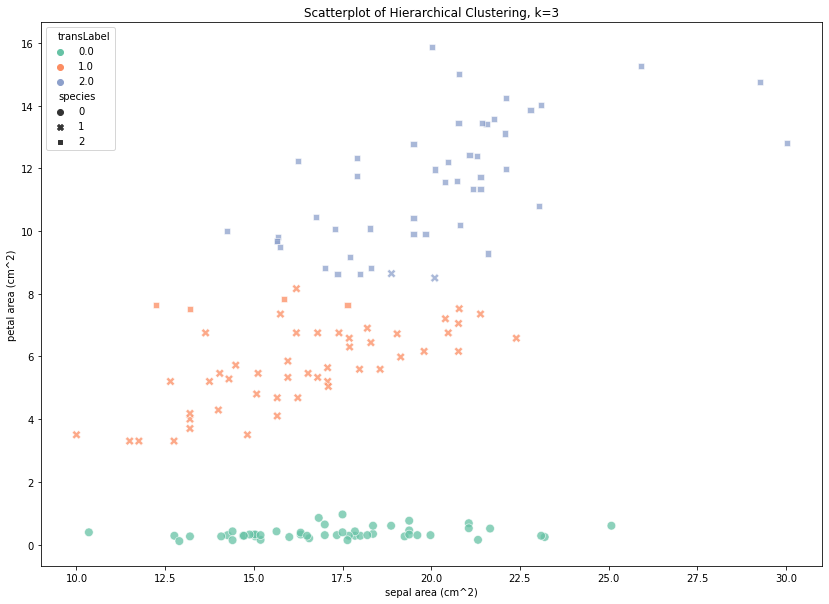

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.scatterplot(data=iris, 
                x="sepal area (cm^2)", 
                y="petal area (cm^2)", 
                hue=agg_results["transLabel"], 
                style=y,
                s=75,
                alpha=0.75,
                palette="Set2",
                ax=ax)
ax.set_title("Scatterplot of Hierarchical Clustering, k=3")

From the confusion matrix, we can see that the hierarchical model was much better at clustering the species $1$ data than the KMeans models. The overreach of cluster $1$ is mostly not seen in this model. From the plot, we can confirm that all the misclassified points fall right on the decision boundary between the clusters.

One additional feature of Hierarchical Models is their ability to create dendrograms. Hierarchical model cluster points by iteratively "merging" the nearest points into the same cluster, so we can create a tree that records the order of those merges. In doing so, it shows which points where closest together.

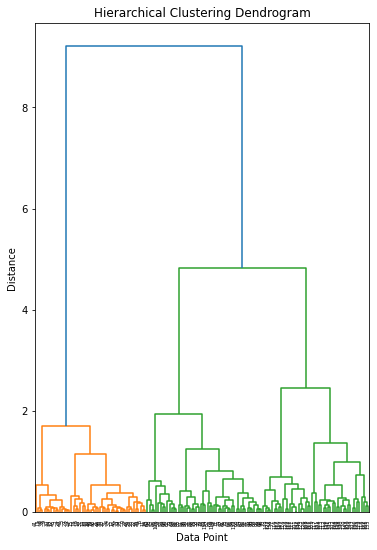

In [22]:
plt.figure(figsize=(6, 9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
    
dendrogram = sch.dendrogram(sch.linkage(x, method='ward'))

Sadly, we have a lot of datapoints so the dendrogram is difficult to read. But it shows us how most of the points are within $1$ unit distance of each other (remember, when scaled using the MinMax Scaler).

We've tested two different clustering algorithms, but there are many more out there. And, helpfully, many are included in SKLearn's clustering package. Let's apply some of them to our data and see how they compare to our KMeans and Hierarchical clustering models.

The first additional algorithm we will look at is Mean Shift Clustering. This algorithm is a centroid based algorithm that aims to discover "blobs" based on their point density, and then updating the centroids to be the mean of the points within a given region. These candidates are then filtered in a post-processing stage to eliminate near-duplicates to form the final set of centroids.

In [23]:
# Create a Mean Shift Model
bandwidth = estimate_bandwidth(x, quantile=0.2)
ms_model = MeanShift(bandwidth = bandwidth, bin_seeding=True).fit(x)
ms_results = pd.DataFrame(list(zip(y, ms_model.labels_)), columns=["species", "cluster"])

# Relabel clusters to match majority of original labels
for c in range(len(ms_results["cluster"].unique())):
    cluster = pd.DataFrame(ms_results[ms_results['cluster'] == c].groupby('species').size())
    cluster.columns=['Size']
    
    new = cluster.index[cluster['Size'] == cluster['Size'].max()].tolist()

    rowIndex = ms_results.index[ms_results['cluster'] == c]
    ms_results.loc[rowIndex, 'transLabel'] = new[0]
    
# Calculate the evaluation metrics for the Mean Shift model
ms_correct = (ms_results['species'] == ms_results['transLabel']).sum()
ms_accuracy = round(ms_correct/ms_results.shape[0],3)

ms_silhouette = round(metrics.silhouette_score(x, ms_results['transLabel'],metric='sqeuclidean'), k)
ms_homogeneity = round(metrics.homogeneity_score(iris['species'], ms_results['transLabel']), k)
ms_completeness = round(metrics.completeness_score(iris['species'], ms_results['transLabel']), k)
ms_vMeasure = round(metrics.v_measure_score(iris['species'], ms_results['transLabel']), k)
ms_adjRand = round(metrics.adjusted_rand_score(iris['species'], ms_results['transLabel']), k)
ms_adjMutual = round(metrics.adjusted_mutual_info_score(iris['species'], ms_results['transLabel']), k)
ms_scores = [ms_accuracy, ms_silhouette, ms_homogeneity, ms_completeness, \
              ms_vMeasure, ms_adjRand, ms_adjMutual]

print("Affinity Propagation:")
print('Accuracy ', ms_accuracy)
print(f"Silhouette Score: {ms_silhouette}")
print(f"Homogeneity Score: {ms_homogeneity}")
print(f"Completeness Score: {ms_completeness}")
print(f"V-Measure Score: {ms_vMeasure}")
print(f"Adjusted Rand Score: {ms_adjRand}")
print(f"adjusted_mutual_info_score: {ms_adjMutual}")

Affinity Propagation:
Accuracy  0.9
Silhouette Score: 0.721
Homogeneity Score: 0.77
Completeness Score: 0.786
V-Measure Score: 0.778
Adjusted Rand Score: 0.745
adjusted_mutual_info_score: 0.767


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [24]:
# Confusion Matrix of Mean Shift
clustering_conf_matrix(ms_results, 3)

array([[50.,  0.,  0.],
       [ 0., 49.,  1.],
       [ 0., 14., 36.]])

Text(0.5, 1.0, 'Scatterplot of Mean Shift Clustering')

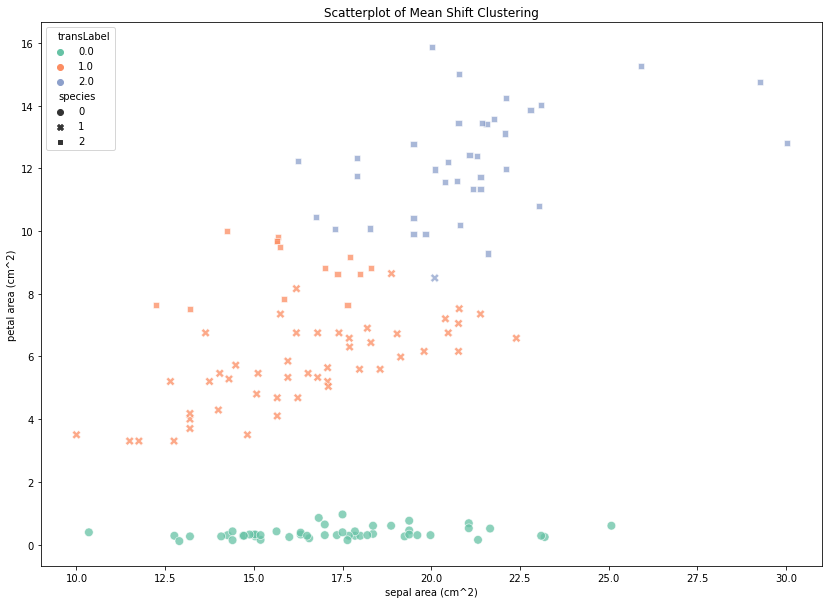

In [25]:
# Scatterplot of points with Mean Shift Clusters
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.scatterplot(data=iris, 
                x="sepal area (cm^2)", 
                y="petal area (cm^2)", 
                hue=ms_results["transLabel"], 
                style=y,
                s=75,
                alpha=0.75,
                palette="Set2",
                ax=ax)
ax.set_title("Scatterplot of Mean Shift Clustering")

The mean shift did well at predicting the species $0$ and $1$ classes, but we can see that a large portion of species $2$ was combined into cluster $1$. Suprisingly (or possibly not), this led to *exact* same evaluations as our KMeans model.

Next, let's look at Spectral Clustering. This algorithm is generally useful when the center and spread of each cluster is not suffiecient to describe each cluster. We know that this has been a problem with the other algorithms, particularly the overlap between species $1$ and $2$. So let's see how spectral clustering does on our dataset. We will note that we tested this model on our PCA dataset, and got very inaccurate results. However, the model was effective when we tried it on the full dataset

In [26]:
# Fit the Spectral Clustering Model
sc_model = SpectralClustering(n_clusters = 3).fit(x)
sc_results = pd.DataFrame(list(zip(y, sc_model.labels_)), columns=["species", "cluster"])

# Reassign cluster names to match majority labels.
for c in range(k):
    cluster = pd.DataFrame(sc_results[sc_results["cluster"] == c].groupby("species").size())
    cluster.columns=["Size"]
    
    new = cluster.index[cluster["Size"] == cluster["Size"].max()].tolist()

    rowIndex = sc_results.index[sc_results["cluster"] == c]
    sc_results.loc[rowIndex, "transLabel"] = new[0]    
    
# Evuluation Metrics
sc_correct = (sc_results['species'] == sc_results['transLabel']).sum()
sc_accuracy = round(sc_correct/sc_results.shape[0],3)

sc_silhouette = round(metrics.silhouette_score(x, sc_results['transLabel'],metric='sqeuclidean'), k)
sc_homogeneity = round(metrics.homogeneity_score(iris['species'], sc_results['transLabel']), k)
sc_completeness = round(metrics.completeness_score(iris['species'], sc_results['transLabel']), k)
sc_vMeasure = round(metrics.v_measure_score(iris['species'], sc_results['transLabel']), k)
sc_adjRand = round(metrics.adjusted_rand_score(iris['species'], sc_results['transLabel']), k)
sc_adjMutual = round(metrics.adjusted_mutual_info_score(iris['species'], sc_results['transLabel']), k)
sc_scores = [sc_accuracy, sc_silhouette, sc_homogeneity, sc_completeness, \
              sc_vMeasure, sc_adjRand, sc_adjMutual]

print("Affinity Propagation:")
print('Accuracy ', sc_accuracy)
print(f"Silhouette Score: {sc_silhouette}")
print(f"Homogeneity Score: {sc_homogeneity}")
print(f"Completeness Score: {sc_completeness}")
print(f"V-Measure Score: {sc_vMeasure}")
print(f"Adjusted Rand Score: {sc_adjRand}")
print(f"adjusted_mutual_info_score: {sc_adjMutual}")

Affinity Propagation:
Accuracy  0.853
Silhouette Score: 0.71
Homogeneity Score: 0.731
Completeness Score: 0.778
V-Measure Score: 0.754
Adjusted Rand Score: 0.663
adjusted_mutual_info_score: 0.728


D:\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [27]:
# Confusion Matrix of Spectral Results
clustering_conf_matrix(sc_results, 3)

array([[50.,  0.,  0.],
       [ 0., 50.,  0.],
       [ 0., 22., 28.]])

Text(0.5, 1.0, 'Scatterplot of Spectral Clustering, k=3')

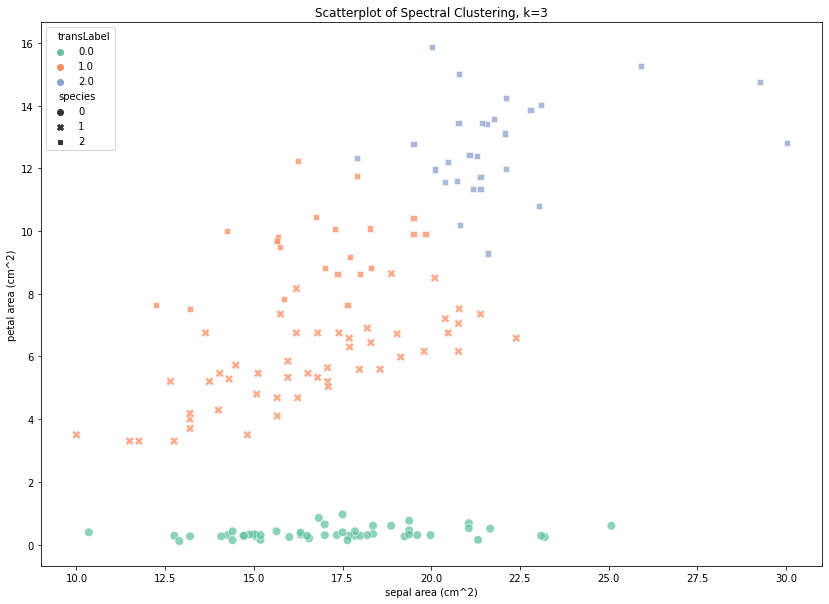

In [28]:
# Scatterplot of points with Mean Shift Clusters
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.scatterplot(data=iris, 
                x="sepal area (cm^2)", 
                y="petal area (cm^2)", 
                hue=sc_results["transLabel"], 
                style=y,
                s=75,
                alpha=0.75,
                palette="Set2",
                ax=ax)
ax.set_title("Scatterplot of Spectral Clustering, k=3")

Spectral clustering did similarly to our other models, but it assigned even more points from species $2$ to cluster $1$. This resulted in a lower accuracy than all of our other models.

At this point, we've utilized multiple different clustering algorithms on our dataset. It may be hard to remember how each one stacked up, so let's create a plot to visualize the results of each one. This should give us a good idea of which model performed the best, overall.

In [29]:
# Create dataframe for the performance of every tested clustering algorithm
evaluations = ["Accuracy", "Silhouette", "Homogeneity", "Completeness", "V-Measure", "Adjusted Rand", "Adjusted Mutual"]
dict = {"Performance":evaluations, "K-Means":km_ori_scores, "Hierarchical":agg_scores, \
        "Mean Shift":ms_scores, "Spectral Clustering":sc_scores}

df_scores = pd.DataFrame(dict)
df_scores

,Performance,K-Means,Hierarchical,Mean Shift,Spectral Clustering
0,Accuracy,0.900,0.960,0.900,0.853
1,Silhouette,0.721,0.668,0.721,0.710
2,Homogeneity,0.770,0.864,0.770,0.731
3,Completeness,0.786,0.864,0.786,0.778
4,V-Measure,0.778,0.864,0.778,0.754
5,Adjusted Rand,0.745,0.886,0.745,0.663
6,Adjusted Mutual,0.767,0.862,0.767,0.728


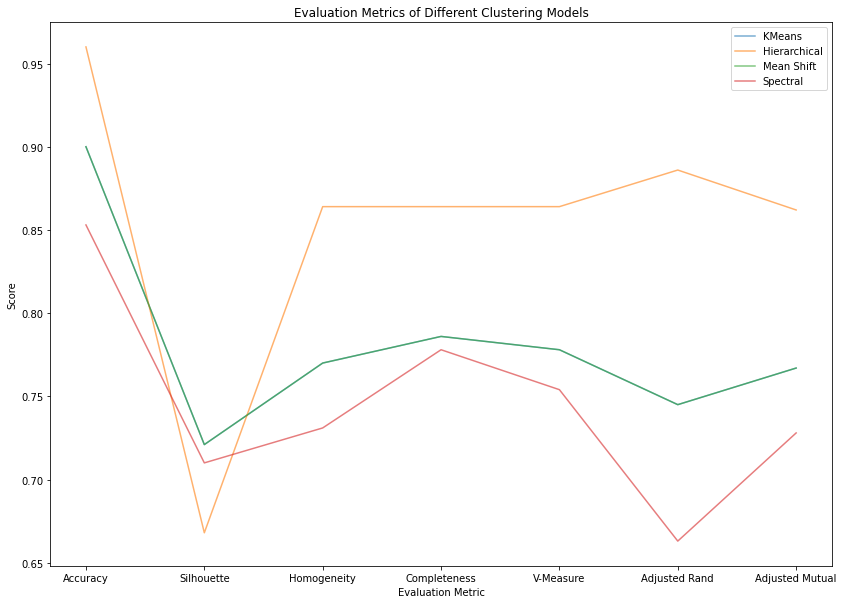

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.lineplot(data=df_scores, x="Performance", y="K-Means", alpha=0.6, label="KMeans", ax=ax)
sns.lineplot(data=df_scores, x="Performance", y="Hierarchical", alpha=0.6, label="Hierarchical", ax=ax)
sns.lineplot(data=df_scores, x="Performance", y="Mean Shift", alpha=0.6, label="Mean Shift", ax=ax)
sns.lineplot(data=df_scores, x="Performance", y="Spectral Clustering", alpha=0.6, label="Spectral", ax=ax)

ax.set_title("Evaluation Metrics of Different Clustering Models")
ax.set_xlabel("Evaluation Metric")
ax.set_ylabel("Score")
ax.legend()

From our plot of evaluations, we can see that the Hierarchical Model performed the best out of our model selection. It had the highest accuracy of clusters matching the actual labels, with about $97\%$ accuracy, and the best overall for all the other statistics as well. Our KMeans model, with $k=3$, performed a bit worse than the hierarchical, and had *exactly* the same performance as our Mean Shift model. The model that performed the worst was the Spectral Clustering model, with the lowest overall evaluation metrics.